In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
import torch.quantization
from tqdm import tqdm 
# import hls4ml

In [21]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

In [53]:
batch = 1024
num_epochs = 40
layers = [32,16,16]
lr = 0.001
df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

model = BinaryClassificationModel()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


losses = []
stt = time.time()
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        # print(f'Epoch {epoch+1}, Estimate:{dtt}, Loss: {loss.item()}')
        t.set_postfix(train_loss=loss.item())


model.eval()
y_pre = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pre.append(predicted)
        
accuracy = correct / total
print(f'Accuracy: {accuracy}')

100%|██████████| 40/40 [02:14<00:00,  3.36s/it, train_loss=0.22] 

Accuracy: 0.9155


In [14]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

'''
batch 
'''

AUC = 0.8399046638262428


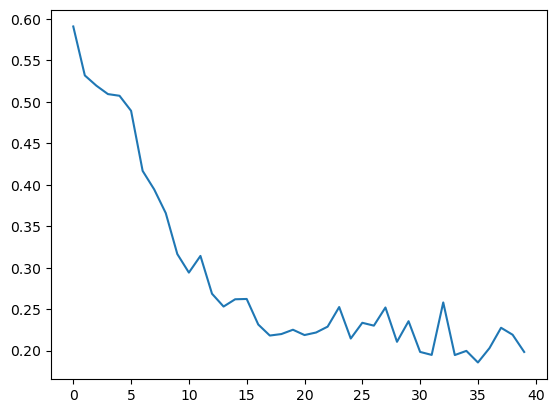

In [18]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losses)):
    lss.append(losses[i].detach())
plt.plot(lss)

In [28]:
AUC(model,test_loader)

AUC = 0.965700067244245


In [29]:
AUC(modelQ,test_loader)

AUC = 0.8528045451987234


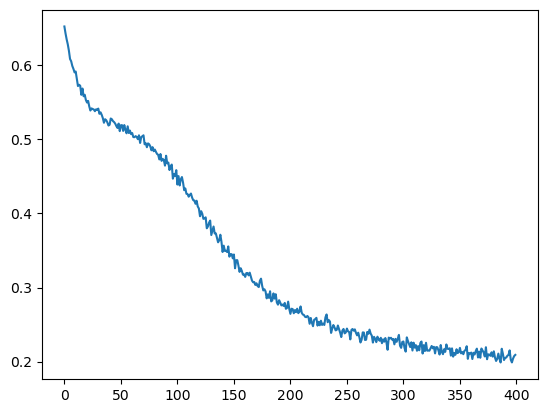

In [111]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losses)):
    lss.append(losses[i].detach())
plt.plot(lss)

In [15]:
batch = 1024
num_epochs = 40
layers = [32,16,16]
lr = 0.001
df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


# class BinaryClassificationModel(nn.Module):
#     def __init__(self):
#         super(BinaryClassificationModel, self).__init__()
#         self.layer0 = nn.Linear(X.shape[1], layers[0])
#         self.layer1 = nn.Linear(layers[0], layers[1])
#         self.layer2 = nn.Linear(layers[1], 1)
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         x = torch.relu(self.layer0(x))
#         x = torch.relu(self.layer1(x))
#         x = self.sigmoid(self.layer2(x))
#         return x

class BinaryClassificationModelQ(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(num_features, layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        x = self.dequant(x)
        return x
modelQ = BinaryClassificationModelQ(X.shape[1])

modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)

def Quantrain(model):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    stt = time.time()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        est = time.time()
        print(f'Epoch {epoch+1}, Estimate:{(est-stt)/(epoch+1)*(num_epochs-epoch-1)}, Loss: {loss.item()}')

    # model.eval()
    model.eval()
    model = torch.quantization.convert(model, inplace=True)
    y_pre = []

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
            
    accuracy = correct / total
    print(f'Accuracy: {accuracy}')
    return losses, model

/vols/cms/hw423/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [18]:
df.shape

(60000, 143)

In [16]:
losess, modelQ = Quantrain(modelQ)

Epoch 1, Estimate:229.96526169776917, Loss: 0.6561436057090759
Epoch 2, Estimate:210.96550583839417, Loss: 0.7207178473472595
Epoch 3, Estimate:202.42954778671265, Loss: 0.8784502148628235
Epoch 4, Estimate:198.10431218147278, Loss: 1.1313062906265259
Epoch 5, Estimate:198.60587573051453, Loss: 1.4663907289505005
Epoch 6, Estimate:191.11991659800213, Loss: 1.970589518547058
Epoch 7, Estimate:184.81755893571037, Loss: 0.626828134059906
Epoch 8, Estimate:178.9995470046997, Loss: 0.5987637639045715
Epoch 9, Estimate:170.2652683522966, Loss: 0.5704667568206787
Epoch 10, Estimate:170.4272174835205, Loss: 0.5673366189002991
Epoch 11, Estimate:169.63030953840777, Loss: 0.5339301228523254
Epoch 12, Estimate:168.3605701128642, Loss: 0.5322490930557251
Epoch 13, Estimate:166.76823806762695, Loss: 0.5251926183700562
Epoch 14, Estimate:159.24129145486015, Loss: 0.5412561297416687
Epoch 15, Estimate:148.279922803243, Loss: 0.5260509252548218
Epoch 16, Estimate:141.7207646369934, Loss: 0.55487591028

KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losess)):
    lss.append(losses[i].detach())
plt.plot(lss)

NameError: name 'losses' is not defined

In [25]:
import os
def model_size(model, label=' '):
    torch.save(model.state_dict(),"/vols/cms/hw423/Acc/mymodel.p")
    size = os.path.getsize("/vols/cms/hw423/Acc/mymodel.p")
    print("model:",label,'\t','Size(KB):',size/1e3)
    os.remove("/vols/cms/hw423/Acc/mymodel.p")
    return size
# compare the size
f = model_size(model, "fp32")
q= model_size(modelQ, "int8")
print("{0:.2f} times smaller".format(f/q))

model: fp32 	 Size(KB): 22.103
model: int8 	 Size(KB): 11.881
1.86 times smaller


In [ ]:
import os
def model_size(model, label=' '):
    torch.save(model.state_dict(),"/vols/cms/hw423/Acc/mymodel.p")
    size = os.path.getsize("/vols/cms/hw423/Acc/mymodel.p")
    print("model:",label,'\t','Size(KB):',size/1e3)
    os.remove("/vols/cms/hw423/Acc/mymodel.p")
    return size
# compare the size
f = model_size(model, "fp32")
q= model_size(model, "int8")
print("{0:.2f} times smaller".format(f/q))